/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:153: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:158: Depreca

Pass 0
Pass 1
Pass 2
Done


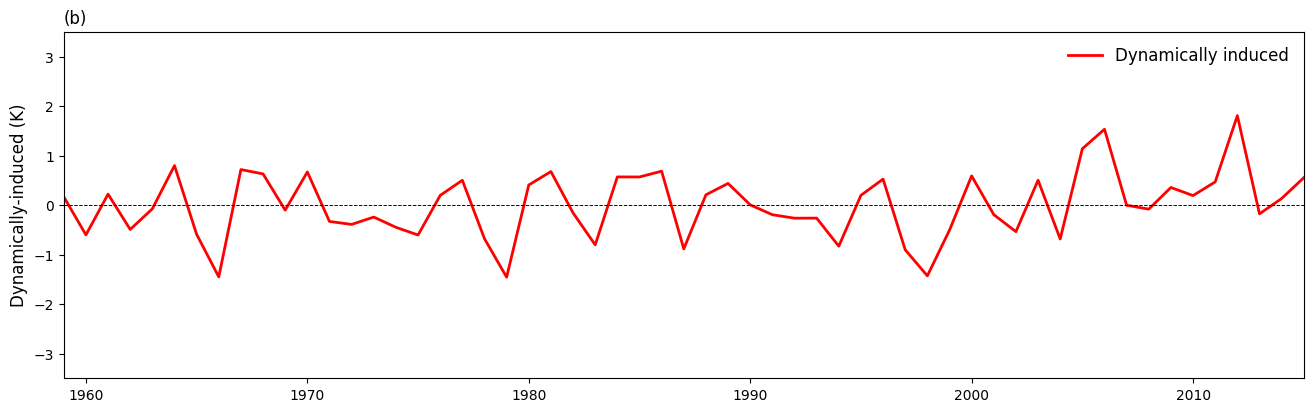

LinregressResult(slope=0.08575165288956776, intercept=-17.030278263868144, rvalue=0.21020132103662442, pvalue=0.11655081128842744, stderr=0.05377900056156976, intercept_stderr=10.680875975100285)


In [9]:
import xarray as xr
import numpy as np
import netCDF4 as nc

from scipy import stats
from bisect import bisect_right

import matplotlib
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression   
from sklearn.linear_model import LinearRegression
from scipy import signal
def detrend_X(X, x_for_plots):
    model = LinearRegression()
    # Detrend X
    X_for_corr_map = np.zeros((X.shape[0],X.shape[1]))
    temp_X_axis = x_for_plots.reshape(len(x_for_plots),1)
    for grid_cell in range(0,X.shape[1]):
        temp_X = X[:,grid_cell]
        model.fit(temp_X_axis, temp_X)
        X_for_corr_map[:,grid_cell] = temp_X - model.predict(temp_X_axis)
    return X_for_corr_map

def detrend_Y(Y, x_for_plots):
    model = LinearRegression()        
    # Detrend Y
    model.fit(x_for_plots.reshape(len(x_for_plots),1), Y)
    Y_for_corr_map = Y - model.predict(x_for_plots.reshape(len(x_for_plots),1))        
    return Y_for_corr_map

## Takes 2/3rds the time as using stats.pearsonr: 
def np_pearson_cor(x, y):
    xv = x - x.mean(axis=0)
    yv = y - y.mean(axis=0)
    xvss = (xv * xv).sum(axis=0)
    yvss = (yv * yv).sum(axis=0)
    result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
    # bound the values to -1 to 1 in the event of precision issues
    return np.maximum(np.minimum(result, 1.0), -1.0)
#for reference steps needed if using stats.pearsonr       
# corr1 = stats.pearsonr(Y_for_corr_map,X_for_corr_map[:,i])
#Y_corr_1[i]=corr1[0]                 # returns r and p (want r)

def PLS_Pass(X,Y, tmp_x_for_plots, Weight_Lat = True):        
    Y_for_corr_map = detrend_Y(Y, tmp_x_for_plots)
    # Get Filtered X for Correlation Matrix
    X_for_corr_map = detrend_X(X, tmp_x_for_plots)
    #Calculate correlation matrices of SLP and SNOTEL
    XY_corr = np.ones((X.shape[1]))
    for i in range(0,X.shape[1]):
        XY_corr[i] = np_pearson_cor(X_for_corr_map[:,i],Y_for_corr_map)
    if Weight_Lat == True:
        # Before Projecting X onto Correlation Matrix (W), Weight W (or X) by Cosine of Lat and Standardize 
        ## populate weight array
        XY_corr_weighted_all_vars = np.ones(X_Flattened_Length)
        for grid_cells in range(0,len(X_var_list)):
            XY_corr_weighted = np.ones((X_dim_1,X_dim_2))
            XY_corr_reshape = XY_corr[(X_dim_1*X_dim_2)*grid_cells:(X_dim_1*X_dim_2)*(grid_cells+1)].reshape(X_dim_1,X_dim_2)
            for long in range(0,XY_corr_reshape.shape[1]):
                XY_corr_weighted[:,long] = XY_corr_reshape[:,long] * weights
            XY_corr_weighted = XY_corr_weighted.reshape(X_dim_1*X_dim_2)
            # Standardize
            XY_corr_weighted /= XY_corr_weighted.std()            
            # Add weighted correlation for variable 
            XY_corr_weighted_all_vars[(X_dim_1*X_dim_2)*grid_cells:(X_dim_1*X_dim_2)*(grid_cells+1)] = XY_corr_weighted        
    else:
        XY_corr_weighted_all_vars = XY_corr        
    XY_corr_weighted = XY_corr_weighted_all_vars    
    return XY_corr_weighted
### Lots of Code for Simply Loading Sea Level Pressure (SLP) Data
### Code was previously set-up to also load/use geopotential height as a predictor,
### but has since been modified and is only up-to-date to use SLP
def areaavg_lat(x,lat):
    nsize=len(x.shape)
    if lat[0]>lat[-1]:
        #find the position of lat>70 for Arctic?
        index =len(lat)- bisect_right(np.flip(lat),70)
        #area avg
        latweights = np.cos(np.deg2rad(lat[:index]))
        #Area weight
        if nsize>3:
            return np.average(np.nanmean(x[:,:,:index],axis=3), axis=2, weights=latweights)
        else:
            return np.average(np.nanmean(x[:,:index],axis=2), axis=1, weights=latweights)
    else:
        #find the position of lat>70 for Arctic?
        index = bisect_right(lat, 70)
        #area avg
        latweights = np.cos(np.deg2rad(lat[index:]))
        #Area weight
        if nsize>3:
            return np.average(np.nanmean(x[:,:,index:],axis=3), axis=2, weights=latweights)
        else:
            return np.average(np.nanmean(x[:,index:],axis=2), axis=1, weights=latweights)
def seasonavg(x,m1,m2,nyear):
    nsize=len(x.shape)
    if nsize>3:
        nlev=len(x[0]);nlat=len(x[0][0]);nlon=len(x[0][0][0])
        x_tavg=np.zeros([nyear,nlev,nlat,nlon])
    elif nsize>2:
        nlat=len(x[0]);nlon=len(x[0][0])
        x_tavg=np.zeros([nyear,nlat,nlon])
    elif nsize==1:
        x_tavg=np.zeros([nyear])
    if m2<m1:
        for iyear in range(0,nyear):
            x_tavg[iyear]=(np.sum(x[iyear*12+12:iyear*12+12+m2],axis=0)+np.sum(x[iyear*12+m1:iyear*12+12],axis=0))/(12+m2-m1)
    else:
        for iyear in range(0,nyear):
            x_tavg[iyear]=np.mean(x[iyear*12+m1:iyear*12+m2],axis=0)
    return x_tavg
def Load(X_var_list,stryr,endyr,m1,m2,latmin,Center=True,Scale=False):    
    prmsl = xr.open_dataset('/home/disk/pna2/aodhan/ArcticAttribution/SLP_NOAA_20thCenturyReanalysisEnsembleMonthlyMean.nc')
    if m1>m2:
        stryr1=stryr-1
    else:
        stryr1=stryr    
    mslp=prmsl.prmsl[(stryr1-1836)*12:(endyr-1835)*12].sel(lat=slice(latmin,90))
    X_dim_1 = int(np.sum(prmsl.lat>=latmin))
    X_dim_2 = len(prmsl.lon)
    ## Get Weights for adjusting area by latitude
    weights = np.cos(np.deg2rad(prmsl.lat[prmsl.lat>=latmin]))
    weights = weights.values # array with dimension of latitude    
    nyear = endyr-stryr+1
    X=seasonavg(mslp,m1,m2,nyear);del mslp
    ## Get Flattened Length to feed to other parts of code
    X_Flattened_Length = X_dim_1*X_dim_2*len(X_var_list)    
        # X = nov_march_mean_mslp.msl.values
    # PLS code centers already
    if Center == True: 
        X_mean = X.mean(axis=0)  ## gets mean for each grid cell across all years
        X -= X_mean
    ## Scale Data (code below is from source code of PLS)
    if Scale == True:
        X_std = X.std(axis=0, ddof=1)
        X_std[X_std == 0.0] = 1.0
        X /= X_std
    X = X.reshape(nyear,X_dim_1*X_dim_2)
    return X, X_Flattened_Length, X_dim_1, X_dim_2, weights

stryr=1959;endyr=2015;nyear=endyr-stryr+1
m1=11;m2=2
stryr1=stryr*1
seasons='JFMAMJJASOND'
if m2-m1>11:
    season='Annual'
elif m2<m1:
    season=seasons[m1:]+seasons[:m2]
    stryr1-=1  ##for DJF read in one previous year
else:
    season=seasons[m1:m2]
ds=nc.Dataset('/home/disk/pna2/aodhan/ArcticAttribution/GriddedMonthlySeaIceExtentAndConcentration.nc')
lat=ds['latitude'][:];lon=ds['longitude'][:]
nlat=len(lat);nlon=len(lon)
sic=ds['seaice_conc'][(stryr1-1850)*12:(endyr-1849)*12]
sic_areaavg=areaavg_lat(seasonavg(sic,m1,m2,nyear),lat);del sic
ds=nc.Dataset('/home/disk/pna2/aodhan/ArcticAttribution/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc')
lat=ds['latitude'][:];lon=ds['longitude'][:]
nlat=len(lat);nlon=len(lon)
t=ds['tas_mean'][(stryr1-1850)*12:(endyr-1849)*12]
t_areaavg=areaavg_lat(seasonavg(t,m1,m2,nyear),lat);del t

######## USER-DEFINED #######
Center = True               ## Whether or not to center X,Y Data
Scale =  True              ## Whether or not to scale X,Y Data
npass = 7              ## define how many passes want to make
X_var_list = ['SLP']        ## code was previously able to incorporate Geopotential Height, but currently set-up to work with SLP as predictor only
latmin = 20     ## Projecting X onto the weighted CC by the cosine of latitude over north of 20Â°N to form a time series and then be standardized
ols_or_sen = 'sen'          ## Use Sen's Slope or OLS when determining Slope of Qx1d Trends
# input_df = annual_flow_stats           ## dataframe that contains Y data want to use
# use = 'Annual_1day_Max_fract_of_mean'  ## Column in Dataframe want to use as Y data (code set-up to use Qx1d)
######## USER-DEFINED #######
indexyr = np.arange(stryr,endyr+1)

### Get Y ###
## Get Y Data into array format for PLS
ipredictand=0 ##0=SAT,1=SIC,2=ARs
if ipredictand==0:
    Y = t_areaavg
elif ipredictand==1:
    Y = sic_areaavg
elif ipredictand==2:
    Y = ar_areaavg
if Center:
    Y-=np.mean(Y)
if Scale:
    Y/=np.std(Y, ddof=1)
### Get Y ###
# Get X
X, X_Flattened_Length, X_dim_1, X_dim_2, weights = Load(X_var_list,stryr,endyr,m1,m2,latmin,Center=Center,Scale=Scale)

#### INITIALIZE ARRAYS WHERE RESULTS ARE STORED ###
# +1 for overall variance
Y_dynadj = np.zeros((npass,nyear))
XY_corr_weighted = np.zeros((npass,X_Flattened_Length))
SLP_contribution = Y*0
### INITIALIZE ARRAYS WHERE RESULTS ARE STORED ###
# LOOP THROUGH EACH STATION AND APPLY PLS
current_pass = 0
####### FIRST PASS #########
print(f'Pass {current_pass}')
XY_corr_weighted[current_pass] = PLS_Pass(X,Y,indexyr)
t_scores = np.ones(nyear)
for l in range(0,nyear):
    t_scores[l]=np.mean(XY_corr_weighted[current_pass]*X[l,:])
t_scores/=np.std(t_scores, ddof=1)    
#Calculate linear regression of t versus data being predicted
reg1=stats.linregress(t_scores,Y)  
#Calculate SLP estimates
SLP_contribution = np.multiply(reg1[0],t_scores)
#Subtract SLP estimates from Y data to yield dynamically-adjusted Y data
Y_dynadj[current_pass] = np.subtract(Y,SLP_contribution)
## NEEDED FOR SECOND PASS
current_pass += 1
if current_pass < npass:   
    # P = vector of regression coefficients for predictor variables X
    P_regression = np.ones((X_Flattened_Length))
    for i in range(0,X_Flattened_Length):
        P_regression[i] = stats.linregress(t_scores,X[:,i])[0]
    # subtract X from SLP time-series multiplied by regression coefficients of X
    X_adj = X - np.dot(t_scores.reshape(nyear,1),P_regression.reshape(X_Flattened_Length,1).T)        
    ####### SECOND PASS #########
    print(f'Pass {current_pass}')
    XY_corr_weighted[current_pass]= PLS_Pass(X_adj,Y_dynadj[current_pass-1],indexyr)
    for l in range(0,nyear):
        t_scores[l]=np.mean(XY_corr_weighted[current_pass]*X_adj[l,:])
    t_scores/=np.std(t_scores, ddof=1)    
    reg1=stats.linregress(t_scores,Y_dynadj[current_pass-1,:])  
    #Calculate SLP estimates 
    SLP_contribution_single_pass = np.multiply(reg1[0],t_scores)
    #Subtract SLP estimates from Y data to yield dynamically-adjusted Y data
    SLP_contribution+= SLP_contribution_single_pass
    Y_dynadj[current_pass] = np.subtract(Y_dynadj[current_pass-1],SLP_contribution_single_pass)

    current_pass += 1
    if current_pass < npass:
        for i in range(0,X_Flattened_Length):
            P_regression[i] = stats.linregress(t_scores,X_adj[:,i])[0]
        # subtract X from SLP time-series multiplied by regression coefficients of X
        X_adj_2 = X_adj-np.dot(t_scores.reshape(nyear,1),P_regression.reshape(X_Flattened_Length,1).T)
        ####### THIRD PASS #########
        print(f'Pass {current_pass}')
        XY_corr_weighted[current_pass]= PLS_Pass(X_adj_2,Y_dynadj[current_pass-1],indexyr)
        for l in range(0,nyear):
            t_scores[l]=np.mean(XY_corr_weighted[current_pass]*X_adj_2[l,:])
        t_scores/=np.std(t_scores, ddof=1)    
        reg2=stats.linregress(t_scores,Y_dynadj[current_pass-1,:])  
        #Calculate SLP estimates of SNOTEL data
        SLP_contribution_single_pass = np.multiply(reg2[0],t_scores)
        #Subtract SLP estimates from Y data to yield dynamically-adjusted Y data
        SLP_contribution += SLP_contribution_single_pass
        Y_dynadj[current_pass] = np.subtract(Y_dynadj[current_pass-1],SLP_contribution_single_pass)
print('Done')
fntsz=12
linew=2;ylimt=3.5
plt.figure(figsize=(16,4.5))
plt.plot(indexyr,SLP_contribution,'r',lw=linew,label='Dynamically induced')
plt.axhline(y = 0,linewidth=linew/3, color='k', linestyle = '--')
plt.legend(frameon=False, fontsize=fntsz)
plt.title('(b)',fontsize=fntsz, loc='left')
plt.ylabel('Dynamically-induced (K)', fontsize = fntsz)
plt.xlim(stryr,endyr)
plt.ylim(-ylimt,ylimt)
plt.show()
decades = np.arange(195.8, 201.5, 0.1)
print(stats.linregress(x=decades, y=SLP_contribution))

LinregressResult(slope=0.09816087975853592, intercept=-19.494750720045218, rvalue=0.21020132103662456, pvalue=0.11655081128842712, stderr=0.061561425695862065, intercept_stderr=12.226518638163805)


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


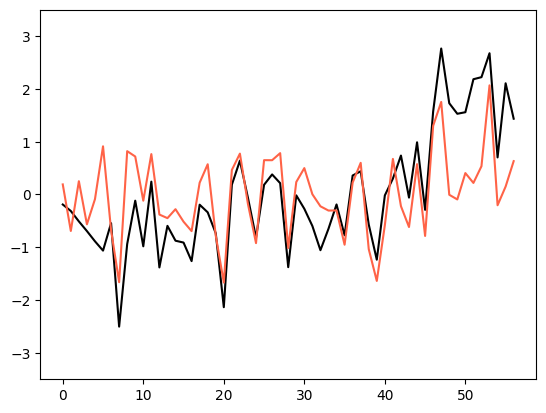

In [10]:
decades = np.arange(195.8, 201.5, 0.1)
t=ds['tas_mean'][(stryr1-1850)*12:(endyr-1849)*12]
t_areaavg=areaavg_lat(seasonavg(t,m1,m2,nyear),lat);del t
t_areaavg = t_areaavg - np.nanmean(t_areaavg)
t_rec = SLP_contribution*stats.linregress(SLP_contribution, t_areaavg)[0] + stats.linregress(SLP_contribution, t_areaavg)[1]
plt.plot(t_areaavg, color='black')
plt.plot(t_rec, color='tomato')
plt.ylim(-3.5,3.5)
print(stats.linregress(x=decades, y=t_rec))

No handles with labels found to put in legend.
No handles with labels found to put in legend.


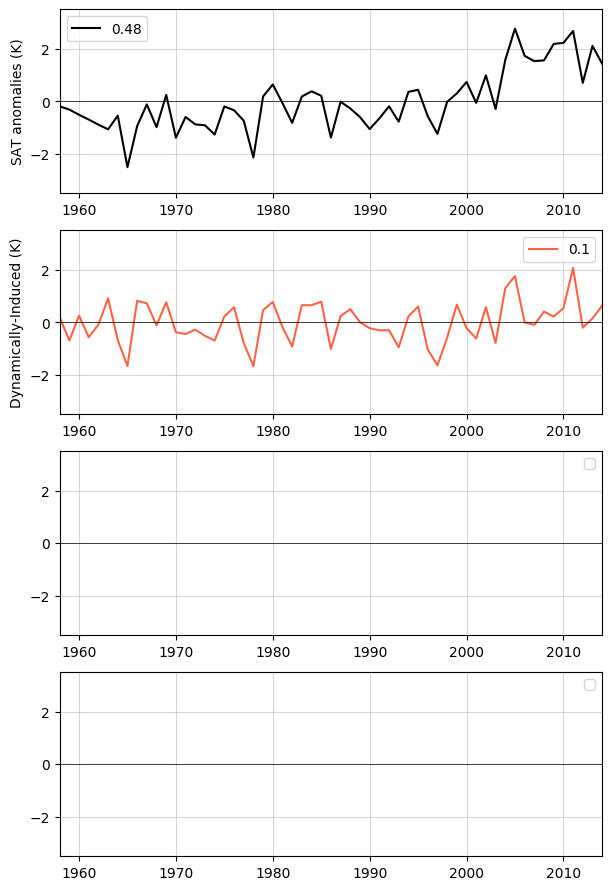

In [11]:
from sklearn.linear_model import LinearRegression

decades = np.arange(195.8, 201.5, 0.1)
fig, axs = plt.subplots(4,1, figsize=(7,11))
################################################################
tas_djf_trend = stats.linregress(x=decades, y=t_areaavg)[0]
#tas_reg_trend = stats.linregress(x=decades, y=Regression_sum)[0]
axs[0].plot(decades*10, t_areaavg, color='black', label=np.around(tas_djf_trend, 2))
#axs[0].plot(decades*10, Regression_sum, color='tomato', label=np.around(tas_reg_trend, 2))
axs[0].set_ylabel('SAT anomalies (K)')
################################################################
dynamical_trend = stats.linregress(x=decades, y=t_rec)[0]
axs[1].plot(decades*10, t_rec, color='tomato', label=np.around(dynamical_trend, 2))
axs[1].set_ylabel('Dynamically-Induced (K)')
################################################################
"""tas_sic_trend = stats.linregress(x=decades, y=tas_sic_induced)[0]
axs[2].plot(decades*10, tas_sic_induced, color='tomato', label=np.around(tas_sic_trend, 2))
axs[2].set_ylabel('Dynamically-Adjusted SIC (K)')
################################################################
tas_co2_trend = stats.linregress(x=decades, y=tas_co2_induced)[0]
axs[3].plot(decades*10, tas_co2_induced, color='tomato', label=np.around(tas_co2_trend, 2))
axs[3].set_ylabel('$CO_{2}$ (K)')
axs[3].set_xlabel('Years')"""
for x in range(4):
    axs[x].plot(decades*10, np.zeros(len(t_areaavg)), color='black', linewidth=0.5)
    axs[x].set_ylim(-3.5,3.5)
    axs[x].set_xlim(1958,2014)
    axs[x].legend()
    axs[x].grid(alpha=0.5)